# Harringtonine CropArray - Cellpose

---

## Notebook summary 


- Load a microscope image of video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Signal quantification and plotting
- Visualization of croparray with Napari

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import trackpy as tp
# Segmenting using cellpose
from cellpose import models, core
from shapely.geometry import Polygon 
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
# Importing croparray
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
ca.print_banner()
# %matplotlib inline 
plt.style.use('dark_background')

 
░█████╗░██████╗░░█████╗░██████╗░░█████╗░██████╗░██████╗░░█████╗░██╗░░░██╗
██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗╚██╗░██╔╝
██║░░╚═╝██████╔╝██║░░██║██████╔╝███████║██████╔╝██████╔╝███████║░╚████╔╝░
██║░░██╗██╔══██╗██║░░██║██╔═══╝░██╔══██║██╔══██╗██╔══██╗██╔══██║░░╚██╔╝░░
╚█████╔╝██║░░██║╚█████╔╝██║░░░░░██║░░██║██║░░██║██║░░██║██║░░██║░░░██║░░░
░╚════╝░╚═╝░░╚═╝░╚════╝░╚═╝░░░░░╚═╝░░╚═╝╚═╝░░╚═╝╚═╝░░╚═╝╚═╝░░╚═╝░░░╚═╝░░░
                                     by : Luis Aguilera and Tim Stasevich 




## File paths


----

In [2]:
img_path = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell02_best.tif') 
print(img_path)

/home/luisub/Desktop/croparray/database/20220210_metabolites_PEP_10mM_Max/MAX_Cell02_best.tif


## Loading data


----

In [3]:
# Video directory
img =  imread(str(img_path)) # F, Y, X, C 
img.shape

(65, 512, 512, 3)

In [4]:
# Converting the video to Croparray format
img_croparray = np.expand_dims(img,axis=0) # adding fov dimenssion
img_croparray = np.expand_dims(img_croparray,axis=2) # adding z dimenssion
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)
img_croparray.shape
print("croparray format shape [fov, f , z, y, x, ch] = ", img_croparray.shape)

croparray format shape [fov, f , z, y, x, ch] =  (1, 65, 1, 512, 512, 3)


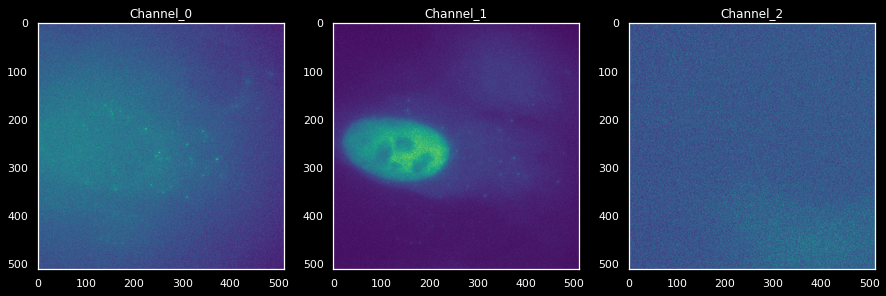

In [5]:
# Plotting original image
selected_time=0
num_channels = img_croparray.shape[5] #3
fig, ax = plt.subplots(nrows=1, ncols=num_channels,figsize=(15,7))
for i in range(0,num_channels):
    ax[i].imshow(np.max(img_croparray[0,selected_time,:,:,:,i] ,axis=0),cmap='viridis' )
    ax[i].grid(False)
    ax[i].set_title('Channel_'+str(i))

## Max projection and masking


----

In [6]:
best_zs = [4,10]
img_max = np.max(img_croparray[0,:,:,:,:,1],axis=1)
img_max.shape

(65, 512, 512)

# Segmenting using cellpose

## Segmenting cytosol

Cellpose detcted  2 cytosol masks


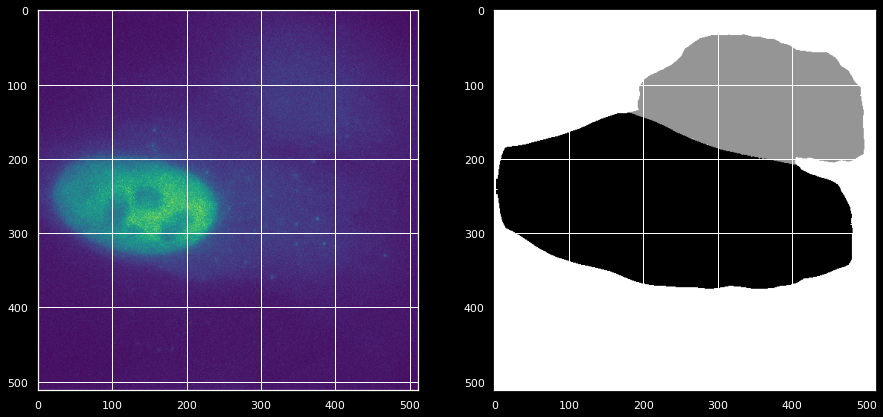

In [7]:
# parameters for cellpose
channels = [0,0]
# Cellpose Model
model = models.Cellpose(gpu=core.use_gpu(), model_type='cyto') # model_type='cyto' or model_type='nuclei'
# Running the models
masks_cyto, flows, styles, diams = model.eval(img_max[selected_time], diameter=300, flow_threshold=None, channels=channels)

print('Cellpose detcted ', str(np.amax(masks_cyto)), 'cytosol masks')

# Plotting
num_col = 2
fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(15,7))
ax[0].imshow(img_max[selected_time],cmap='viridis' )
ax[1].imshow(masks_cyto,cmap='Greys')
plt.show()

## Segmenting the nucleus

Cellpose detcted  1 nucleus masks


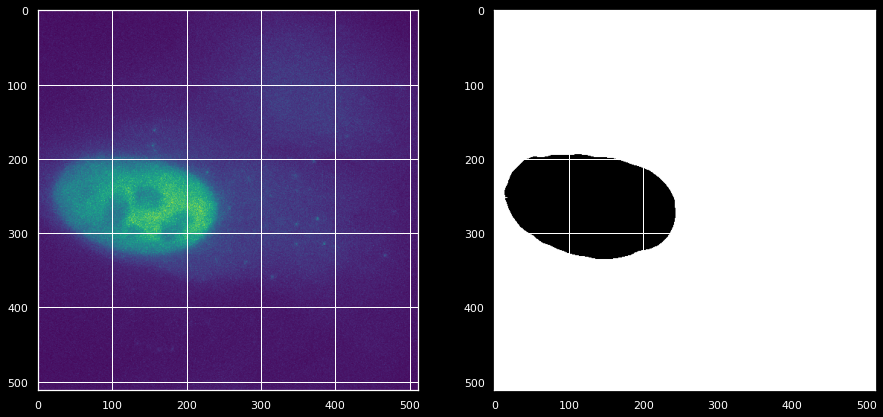

In [8]:
# Cellpose model
model = models.Cellpose(gpu=core.use_gpu(), model_type='nuclei') # model_type='cyto' or model_type='nuclei'
# Running the models
masks_nuc, flows, styles, diams = model.eval(img_max[selected_time], diameter=200, flow_threshold=None, channels=channels)

print('Cellpose detcted ', str(np.amax(masks_nuc)), 'nucleus masks')

# Plotting
num_col = 2
fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(15,7))
ax[0].imshow(img_max[selected_time],cmap='viridis' )
ax[1].imshow(masks_nuc,cmap='Greys')
plt.show()

The following code removes cytosol masks that do not contain a cytosol.

In [9]:
# Keeping only masks with nucleus
def is_nucleus_in_cytosol(mask_n, mask_c):
    ''' This function detects if a cytosol has a nucleus. Returns 1 if true.'''
    mask_n[mask_n>1]=1
    mask_c[mask_c>1]=1
    size_mask_n = np.count_nonzero(mask_n)
    mask_combined =  mask_n + mask_c
    sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
    if (sum_mask> size_mask_n*0.8): # the element is inside if the two masks overlap over the 80% of the smaller mask.
        return 1
    else:
        return 0

In [10]:
# Looking if the mask has a nucleus
number_cytosols = np.amax(masks_cyto)
is_cyto_with_a_nucleus = np.zeros(number_cytosols,dtype='int') # prealocating an array
for i in range (1,number_cytosols+1): # iterating for each mask in the cytosol 
    masks_cyto_temp =  np.where(masks_cyto == i, 1, 0)
    is_cyto_with_a_nucleus[i-1] = is_nucleus_in_cytosol(masks_nuc, masks_cyto_temp)

# removing cytosol masks without nucleus
masks_cyto_complete = np.zeros_like(masks_cyto) # Prealocating an array to contain the final masks 
counter = 1
for i in range (1,number_cytosols+1): # iterating for each mask in the cytosol 
    if is_cyto_with_a_nucleus[i-1] == True:
        # Keeping only the masks with a  nucleus
        masks_cyto_complete =  np.where(masks_cyto == i, counter, 0) 
        counter+=1
# cytosol without nucleus
masks_cyto_no_nucleus = masks_cyto_complete - masks_nuc


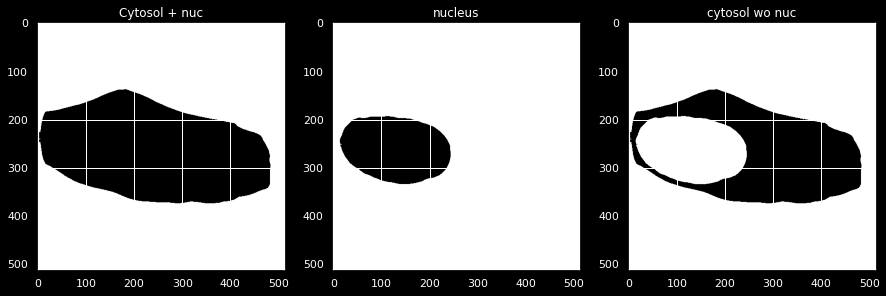

In [11]:
# Plotting
num_col = 3
fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(15,7))
ax[0].imshow(masks_cyto_complete,cmap='Greys' )
ax[0].set_title('Cytosol + nuc')
ax[1].imshow(masks_nuc,cmap='Greys')
ax[1].set_title('nucleus')
ax[2].imshow(masks_cyto_no_nucleus,cmap='Greys')
ax[2].set_title('cytosol wo nuc')
plt.show()


masked image shape (65, 512, 512)


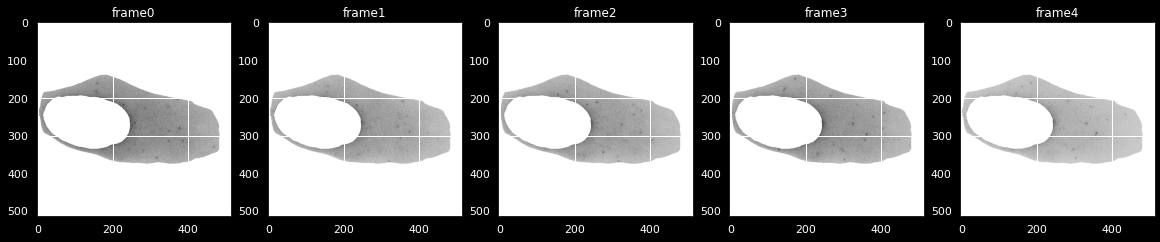

In [12]:
# apply the mask to the complete movie
masked_img = np.multiply(img_max,masks_cyto_no_nucleus)

print('masked image shape', str(masked_img.shape))

# plotting some frames of the masked image
num_col = 5
fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(20,7))
for i in range(0,num_col):
    ax[i].imshow(masked_img[i],cmap='Greys')
    ax[i].set_title('frame'+str(i) )
plt.show()

In [37]:
from skimage import measure


(751, 2)


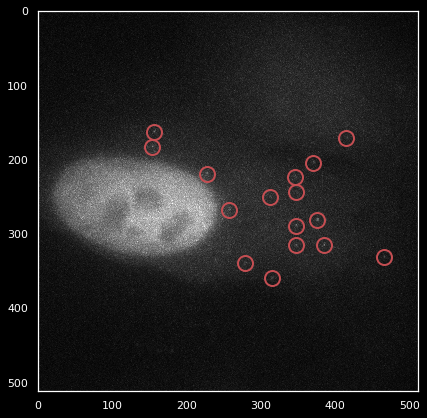

In [84]:
# Finding good settings: 'Detect test' button
selected_channel = 1
selected_time=10
particle_diameter=7
min_m = 800

# locate spots in a given time
f = tp.locate(img_max[0], particle_diameter,minmass=min_m)
contour = measure.find_contours(masks_cyto_no_nucleus, 0.8)
contour_reordered = np.zeros_like(contour[1])
contour_reordered[:,0] = contour[1][:,1]
contour_reordered[:,1] = contour[1][:,0]
#contour_reordered = np.moveaxis(contour[1], 0,1)


# Choose points outside mask
poly = Polygon( contour_reordered ) # This is a polygon that defines the mask
mypts = np.transpose([f.x, f.y]) # These are the points detected by trackpy
f['In Nucleus']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  

# The desired points should show up as a layer in napari
plt.figure(figsize=(7, 7))
plt.grid(False)
tp.annotate(f[f['In Nucleus']==False], img_max[0])
plt.show()


In [67]:
f


,y,x,mass,size,ecc,signal,raw_mass,ep,In Nucleus
460,162.276843,156.048033,1525.727479,1.532495,0.139661,168.774775,29290.0,0.062677,False
489,170.504761,414.736407,958.496763,1.740261,0.184098,89.602058,26647.0,0.083693,False
527,182.845236,153.900701,1364.625919,1.485005,0.083151,166.953335,31162.0,0.053213,False
572,203.997150,370.317015,1423.850674,1.568912,0.015905,142.375880,27384.0,0.076537,False
590,210.751134,159.019182,1199.633827,1.778993,0.212682,81.753090,48144.0,0.022455,False
609,218.758176,91.075358,832.130380,1.528577,0.290342,93.464629,49107.0,0.021742,False
612,218.847405,226.900648,1685.291201,1.366488,0.177754,225.243404,34406.0,0.042177,True
621,221.967089,170.306107,1172.671725,1.686535,0.130788,122.383980,56847.0,0.017323,False
627,223.084653,345.259535,911.626642,1.711251,0.296001,87.337241,28646.0,0.066762,False
632,226.067639,190.179999,969.621127,1.744220,0.327762,92.346201,54895.0,0.018259,False


In [14]:
raise

RuntimeError: No active exception to reraise

Now you can create a mask to exclude regions, if desired

In [ ]:
# Create mask from Shapes layer in napari  
#width, height = img_croparray.shape[3:5]
#polygon=viewer.layers['nucleus'].data[0]
#polygon_c = viewer.layers['cell'].data[0]
#poly_path=Path(polygon)
#poly_path_c = Path(polygon_c)

#x, y = np.mgrid[:height, :width]
#coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

#mask = poly_path_c.contains_points(coors)
#mask = mask.reshape(height, width)
#mask2 = np.logical_not(mask)

# The masked image should show up as a layer in napari
#plt.figure(figsize=(7, 7))
#plt.grid(False)
#plt.imshow(mask*img_max[0], cmap='gray')

In [ ]:
# Finding good settings: 'Detect test' button
selected_channel = 1
particle_diameter=7
min_m = 1000

plt.figure(figsize=(7, 7))
plt.grid(False)
f = tp.locate(img_max[0], particle_diameter,minmass=min_m)

# Choose points outside mask
polygonxy = np.transpose([polygon[:,1],polygon[:,0]]) # napari has x and y swapped compared to trackpy
poly = Polygon(polygonxy)  # This is a polygon that defines the mask
mypts = np.transpose([f.x,f.y]) # These are the points detected by trackpy
f['In Nucleus']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  

# The desired points should show up as a layer in napari
tp.annotate(f[f['In Nucleus']==False], img_max[0])

If satisfied, then process the entire movie the same way:

In [ ]:
f = tp.batch(img_max, diameter=particle_diameter,minmass=min_m)
f_list = []
for i in np.arange(len(f['frame'].unique())):
    f0 = f[f['frame']==i]
    f1 = f0.copy()

    # Label points in cell
    polygonxy_c = np.transpose([polygon_c[:,1],polygon_c[:,0]]) # Napari has x and y swapped compared to trackpy
    poly_c = Polygon(polygonxy_c)  # This is a polygon that defines the mask
    mypts = np.transpose([f1.x,f1.y]) # These are the points detected by trackpy
    f1['In Cell']=[poly_c.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  

    # Label points in nucleus
    polygonxy=np.transpose([polygon[:,1],polygon[:,0]]) # Napari has x and y swapped compared to trackpy
    poly = Polygon(polygonxy)  # This is a polygon that defines the mask
    f1['In Nucleus']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
    
    f_list.append(f1)
f_all = pd.concat(f_list)
f_all.to_csv(os.path.join(dir,img_4D_filename[:-4]+'.csv'))
f_all

Convert f to crop_array format

In [ ]:
#only if you didn't track:
spots = f_all.copy() # Nice to copy; seems it can cause to overwrite otherwise
spots['id']=spots.index
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp'}, 
inplace=True, errors='raise')
spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp','In Cell','In Nucleus']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

## Create Crop Array
____

Create a crop array from 4D movie

In [ ]:
my_ca = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'], name = os.path.join(dir,img_4D_filename))
my_ca

## Save the crop array
____

In [ ]:
my_ca.to_netcdf(os.path.join(dir,img_4D_filename[:-4]+'.nc') )

## Quantify signal intensity through time
____

In [ ]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca, ref_ch=1, disk_r=3, roll_n=3)

In [ ]:
my_ca.best_z.mean('n').sel(fov=0,ch=1).rolling(t=3,min_periods=1).mean().plot.imshow(col='t',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,cmap='gray', vmin=0, vmax =200)

Let's compare our disk-donut 'signal' layer (acquired from 3D image) to trackpy's (acquired from max-projection):

In [ ]:
# Let's compare our intensity numbers to those from trackpy:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='signal_tp',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

Let's look at average signal vs time

In [ ]:
# Let's look at average signal vs time
start_sig = my_ca.signal.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0,ch=1).plot.line(x='t',hue='ch')

Now let's just use trackpy's values:

In [ ]:
# Let's look at average signal vs time
start_sig = my_ca.signal_tp.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal_tp.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal_tp.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0).plot.line(x='t',hue='ch')

I guess trackpy and the disk donut method do a very good job at getting the intensities of spots. Although note that trackpy got the values from the max-intensity projection. Interesting.

## Visualize crop array montage with Napari
___

Now let's see a montage of the selected spots' best-z planes:

In [ ]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_ca.sel(fov=0,ch=0).best_z,row='n',col='t'),contrast_limits=[60,800])

## Optional: Create Track Array
___

In [ ]:
f_all

In [ ]:
# Note, if you actually wanted to track, you could use the following:
# link tracks
max_distance_movement = 15
track_skip_frames = 3
min_trajectory_length = 10
t = tp.link(f_all, max_distance_movement, memory=track_skip_frames)
t1 = tp.filter_stubs(t, min_trajectory_length)
t1['particle'] = t1['particle']+1 # VERY IMPORTANT NOT TO HAVE TRACK IDs WITH VALUES = 0 WHEN MAKING CROP ARRAYS AS ZERO IS DEFAULT EMPTY VALUE
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique()) 

In [ ]:
# only if you tracked:
spots = t1.copy()
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp','particle':'id'}, 
inplace=True, errors='raise')


spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

In [ ]:
my_ca2 = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'])

In [ ]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca2, ref_ch=1, disk_r=3, roll_n=3)

In [ ]:
import xarray as xr
import pandas as pd
# Since ids correspond to tracks, we can organize tracks in rows  
my_ids = np.unique(my_ca2.id) # Find all unique ids
my_ids = my_ids[1:] # remove the '0' ID used as filler in Crop Arrays
my_ids
# Get a list of xarrays for each unique id 
my_das = []
for i in np.arange(len(my_ids)):
    temp = my_ca2.groupby('id')[my_ids[i]].reset_index('stacked_fov_n_t').reset_coords('n',drop=True).reset_coords('fov',drop=True).swap_dims({'stacked_fov_n_t':'t'})
    my_das.append(temp)
    del temp
# Concatenate the xarrays together to make a new xarray dataset in a track array format (each track on separate row). Here 'n' is replaced by 'tracks'
my_taz = xr.concat(my_das, dim=pd.Index(my_ids, name='track_id'), fill_value=255) # fill_value=0 so keep int instead of moving to floats with NaNs
my_taz = my_taz.transpose('track_id','fov','n','t','z','y','x','ch', missing_dims='ignore') # reorder for napari
my_taz

In [ ]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_taz.sel(ch=1).best_z,row='track_id',col='t'),contrast_limits=[60,800])

In [ ]:
my_taz.isel(track_id=[12,16,20]).sel(ch=1).signal.plot.line(x='t',col='track_id',col_wrap=3)

# Trying to track in x, y, and z:

Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer

In [ ]:
max_distance_movement = 5
track_skip_frames = 3
my_frame = 15
min_trajectory_length=2
my_list = []
for my_frame in np.arange(len(img_croparray[0,:])): #np.arange(15,16,1):
    f = tp.batch(img_croparray[0,my_frame,:,:,:,1], diameter=7,minmass=1000)
    t1 = tp.link(f, max_distance_movement, memory=track_skip_frames)
    t = tp.filter_stubs(t1, min_trajectory_length)
    sort_t = t.sort_values(['particle']).groupby('particle').aggregate('max').reset_index().rename(columns={'frame':'z'})
    sort_t['t']=my_frame
    my_list.append(sort_t)
my_df = pd.concat(my_list)
my_df.reset_index()

In [ ]:
import pandas as pd
my_df = pd.concat(my_list)
my_df.reset_index()

In [ ]:
my_df['raw_mass'].hist()

In [ ]:
plt.figure(figsize=(20,10))
tp.annotate(my_df[(my_df['t']==28)&(my_df['raw_mass']<40000)], img_4D_max_real[28]);

In [ ]:
np.array([len(t[t['particle']==i].x) for i in np.arange(len(t.particle))])

In [ ]:
f[f['frame']==6]